# 时间序列的基本特征

本讲以 `pandas_datareader` 为例，介绍如何获取宏观数据，以及时间序列的基本特征和分析流程。

FRED 是美国联邦储备银行提供的宏观经济数据，包含了大量的经济指标。
FRED 提供了一个 API 接口，可以通过 `pandas_datareader` 来获取数据。

本文写作过程中借助了 AI，包括 ChatGPT ([提示词](https://chatgpt.com/share/6818e458-538c-8005-9af1-1a8c31ee50f1)) 和 Github Coplilot。

## 下载美国失业率数据

> Source: U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis; <https://fred.stlouisfed.org/series/UNRATE>, May 5, 2025. 

In [1]:
# 基本设定

import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import datetime

import warnings
warnings.filterwarnings("ignore")  # 屏蔽警告信息

# 设置起止日期 (后续其他宏观变量也采用这个设置)
start_date = datetime.datetime(1960, 1, 1)
end_date = datetime.datetime.today()
start_year = start_date.year

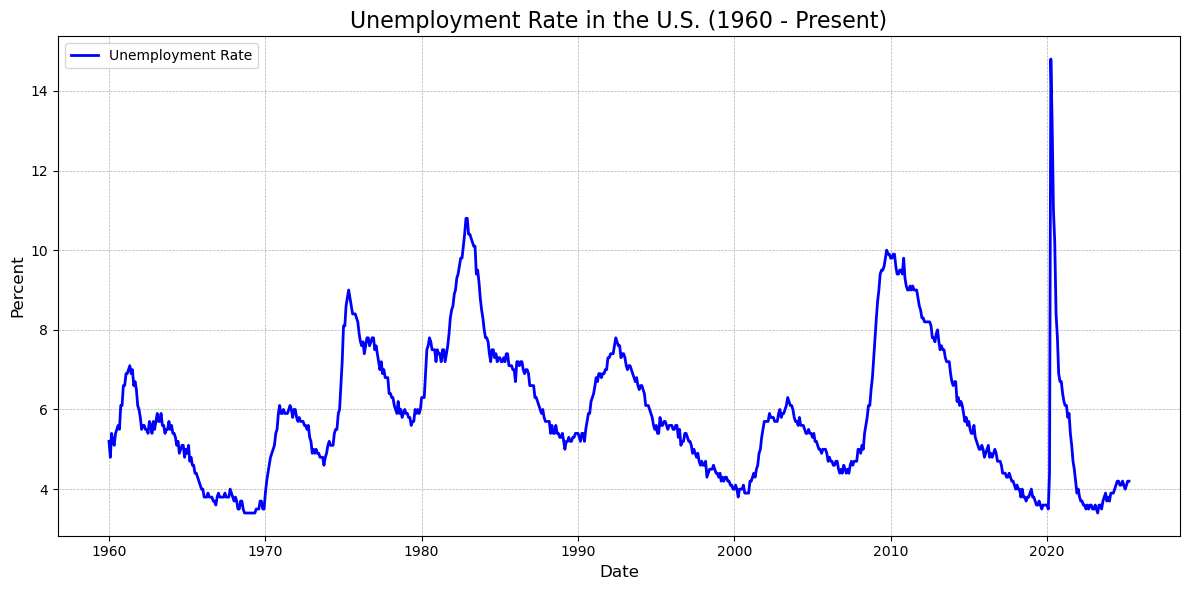

In [2]:
# 失业率

# 从 FRED 获取“Unemployment Rate”数据（代码为 UNRATE）
df_unemp = DataReader("UNRATE", "fred", start_date, end_date)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_unemp.index, df_unemp["UNRATE"], 
         color='blue', linewidth=2, label='Unemployment Rate')

# 图形美化
plt.title(f"Unemployment Rate in the U.S. ({start_year} - Present)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percent", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# 显示图形
plt.show()


## 美国失业率的时序特征

上图展示了自 1960 年以来美国的月度失业率变化趋势。总体来看，美国失业率呈现出显著的**周期性波动**，其高峰通常与经济衰退期相吻合，低谷则出现在经济扩张阶段。

- **周期波动明显**：失业率大致每 8-10 年出现一次较大波动，与美国历次经济衰退（如 1974、1982、1991、2008 和 2020 年）高度对应。
- **历史极值**：2020 年新冠疫情爆发初期，失业率迅速飙升至超过 14%，为图中最高点，反映出突发公共卫生事件对劳动市场的巨大冲击。
- **长期下行趋势**：尽管存在周期性波动，但在部分阶段（如 1982-2000 年间、2010-2019 年间）可观察到失业率逐步下降的趋势，显示出结构性改善可能性。

### 问题：如何分析失业率的时序特征？

从图中失业率的走势出发，我们可以从以下几个角度提出计量建模中需要关注的核心问题：

* **平稳性与周期性：**
  失业率呈现一定的均值回复特征 (在上图中，均值约为 6Z%)，但是否真正平稳？如何通过单位根检验（如 ADF 检验）判断？如果该序列非平稳，我们是否应进行差分处理以便后续建模？

* **结构性突变：**
  例如 2020 年的断崖式上升显然并非常态波动，这提示我们应考虑模型中可能存在的**结构突变（structural break）**。在传统 ARIMA 模型之外，我们可能需要引入 regime-switching 或 dummy 变量来捕捉这类异质性。

* **滞后依赖结构：**
  当前失业率是否受到过去若干期值的影响？其滞后项在建模中如何体现？这正是 AR(p) 或 ARMA(p, q) 模型关注的核心。

* **长期关系与协整：**
  若将失业率与其他宏观变量（如通货膨胀率、GDP 增长率）联合考虑，它们之间是否存在协整关系？若存在，应如何建立误差修正模型（ECM）？

* **波动性建模：**
  某些阶段的波动显著大于其他时期，例如 1970s 或 2008 危机期间。如何刻画这种**条件异方差**特征？这将引出 ARCH/GARCH 及其扩展模型的讨论。


In [3]:
# 失业率的基本统计特征
umemp = df_unemp["UNRATE"]
print("失业率的基本统计特征：")
print(umemp.describe().round(2))

失业率的基本统计特征：
count    784.00
mean       5.88
std        1.70
min        3.40
25%        4.60
50%        5.60
75%        7.00
max       14.80
Name: UNRATE, dtype: float64


In [4]:
# 分时段统计 (表格版)
periods = {
    "1960-1980年": ("1960-01-01", "1980-12-31"),
    "1980-2000年": ("1980-01-01", "2000-12-31"),
    "2000-2010年": ("2000-01-01", "2010-12-31"),
    "2010-2020年": ("2010-01-01", "2020-12-31"),
    "2020-2025年": ("2020-01-01", "2025-12-31"),
}

# 创建一个列表来存储结果
stats_list = []

for period, (start, end) in periods.items():
    stats = umemp[start:end].agg(['mean', 'std', 'min', 'max']).round(2)
    stats_list.append({
        "Period": period,
        "Mean": stats["mean"],
         "Std": stats["std"],
         "Min": stats["min"],
         "Max": stats["max"]
    })

# 将结果转换为 DataFrame
stats_table = pd.DataFrame(stats_list)

# 显示结果表格
print(stats_table)

       Period  Mean   Std  Min   Max
0  1960-1980年  5.58  1.35  3.4   9.0
1  1980-2000年  6.40  1.55  3.8  10.8
2  2000-2010年  5.91  1.81  3.8  10.0
3  2010-2020年  6.39  2.29  3.5  14.8
4  2020-2025年  4.90  2.28  3.4  14.8


## 10 年移动平均

我们可以使用 `rolling` 函数来计算 10 年移动平均，以便从更长时间尺度上观察失业率的变化趋势。


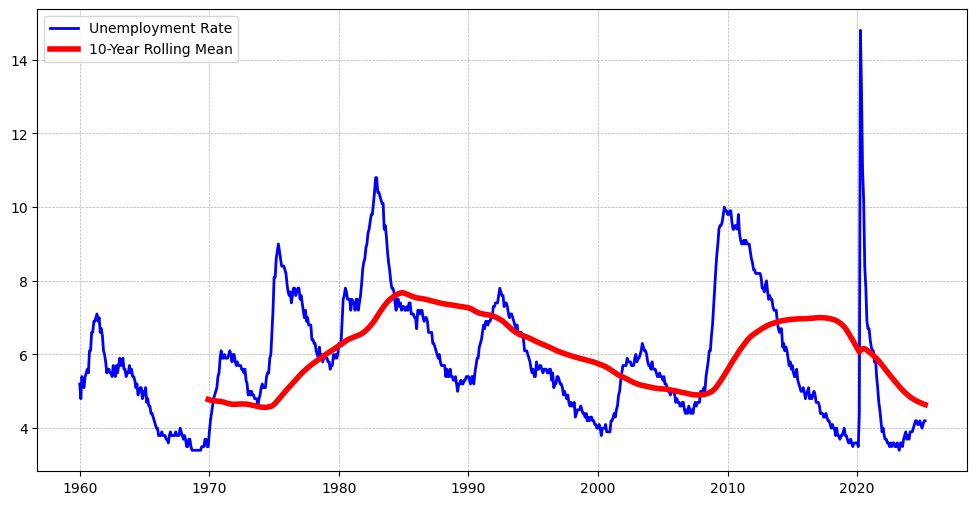

In [5]:
# 10 年和 5 年滚动平均
rolling_mean_umemp_10yr = umemp.rolling(window=120).mean()  # 120 个月 = 10 年

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_unemp.index, umemp, 
         color='blue', linewidth=2, label='Unemployment Rate')
plt.plot(df_unemp.index, rolling_mean_umemp_10yr, 
         color='red', linewidth=4, label='10-Year Rolling Mean')
plt.legend() # 添加图例
plt.grid(True, linestyle='--', linewidth=0.5) # 添加网格线

## 消费者物价指数（CPI）

> Source: U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average, Not Seasonally Adjusted [CPIAUCNS], retrieved from FRED, Federal Reserve Bank of St. Louis; <https://fred.stlouisfed.org/series/CPIAUCNS>, May 5, 2025.

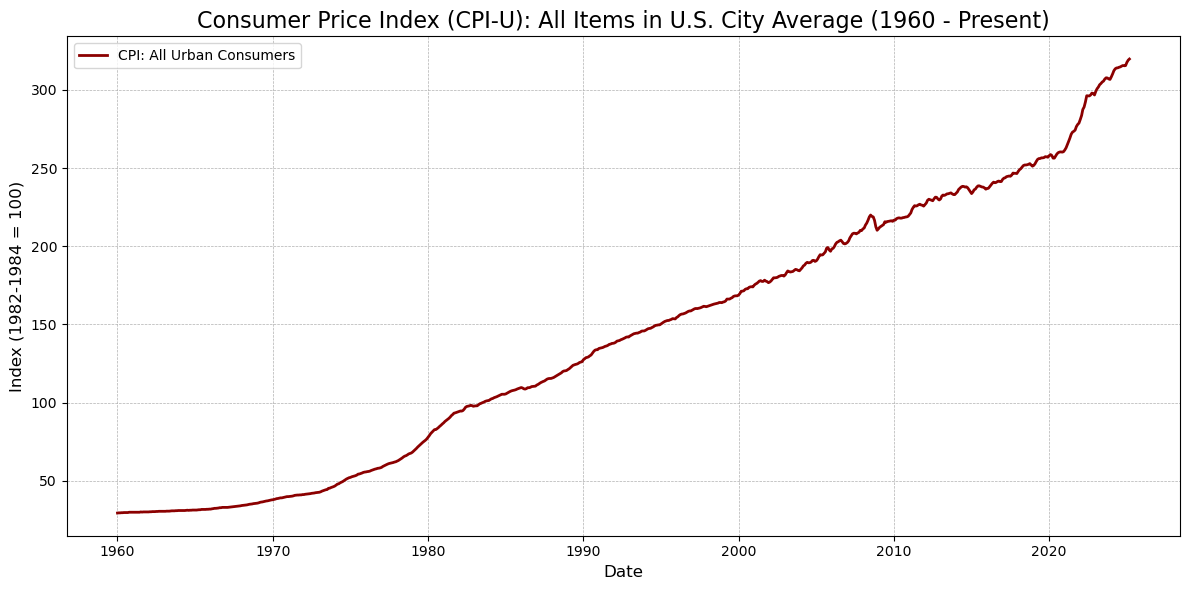

In [6]:
# CPI（消费者物价指数）

# 从 FRED 获取 CPI 数据（代码为 CPIAUCNS）
df_CPI = DataReader("CPIAUCNS", "fred", start_date, end_date)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_CPI.index, df_CPI["CPIAUCNS"], 
         color='darkred', linewidth=2, label='CPI: All Urban Consumers')

# 图形美化
plt.title(f"Consumer Price Index (CPI-U): All Items in U.S. City Average ({start_year} - Present)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Index (1982-1984 = 100)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# 显示图形
plt.show()


### 美国消费者物价指数（CPI）趋势图解读

上图展示了自 1960 年以来美国城市居民的消费者物价指数（CPI-U）的长期变化趋势，数据来自 FRED 数据库，基期设为 1982-1984 年的平均水平（指数 = 100）。

从图中可以观察到以下几个重要特征：

* **总体呈上升趋势**：说明过去几十年美国总体价格水平持续上升，具有显著的通货膨胀特征。
* **1970s 的急剧上升**：受石油危机影响，1970 年代出现了显著的高通胀，CPI 增速明显加快。
* **1980s 以后趋于稳定增长**：随着货币政策收紧（如沃尔克加息），通胀得到控制，CPI 增长变得更加平缓。
* **2020 年以后的陡峭上升**：反映出疫情后期以及地缘政治冲击下，美国面临新一轮较高通胀压力，物价上涨速度明显加快。

接下来，我们可以看看最近 10-20 年的 CPI 变化趋势。

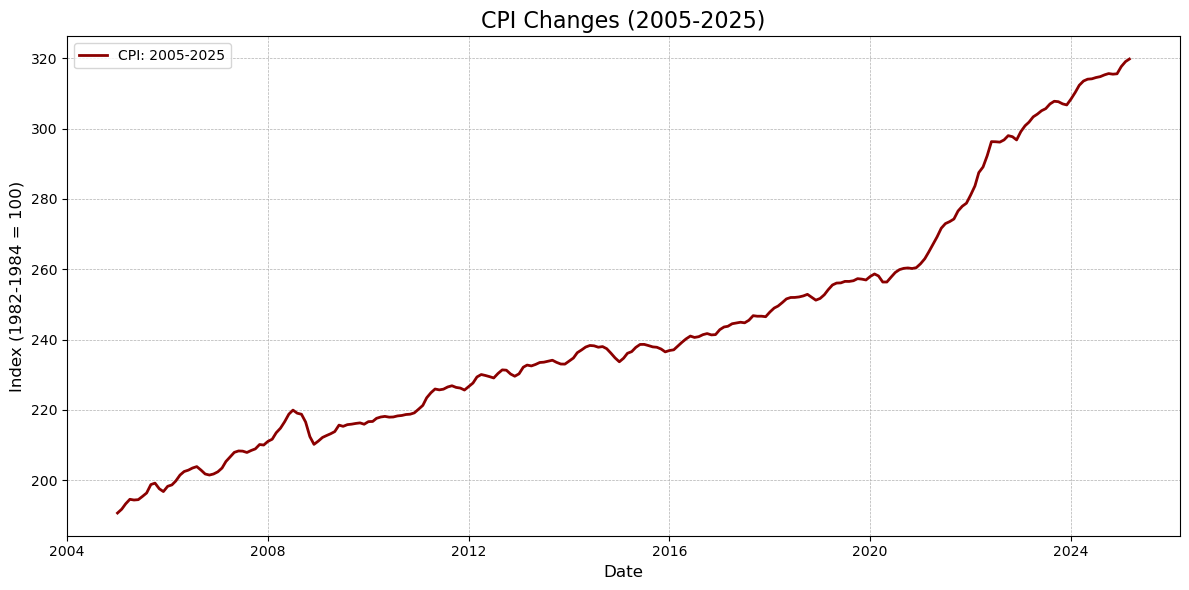

In [7]:
# 2005 以来的 CPI 变化
start_year = 2005
end_year = 2025

df_CPI_period = df_CPI["CPIAUCNS"][f"{start_year}-01-01":f"{end_year}-12-31"]

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_CPI_period.index, df_CPI_period, 
         color='darkred', linewidth=2, label=f'CPI: {start_year}-{end_year}')

# 图形美化
plt.title(f"CPI Changes ({start_year}-{end_year})", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Index (1982-1984 = 100)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# 显示图形
plt.show()

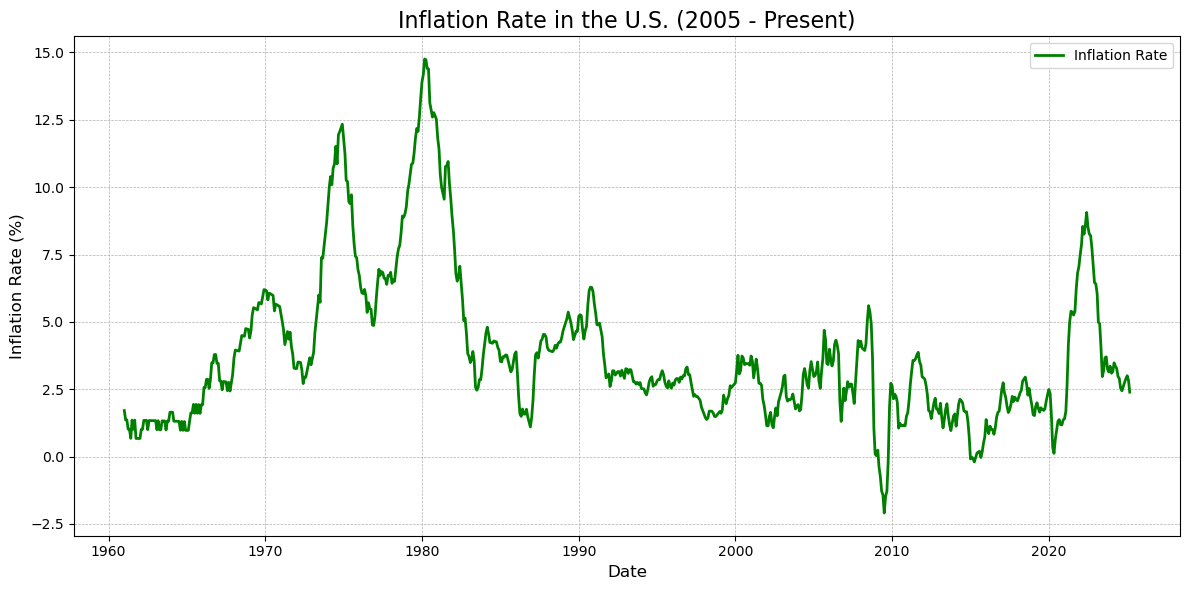

In [8]:
# 基于 CPI 计算通货膨胀率

# 计算通货膨胀率（基于 CPI 的同比变化率）
df_CPI['Inflation Rate'] = df_CPI['CPIAUCNS'].pct_change(periods=12) * 100

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_CPI.index, df_CPI['Inflation Rate'], 
         color='green', linewidth=2, label='Inflation Rate')

# 图形美化
plt.title(f"Inflation Rate in the U.S. ({start_year} - Present)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# 显示图形
plt.show()

## 失业率和通货膨胀率的关系

接下来，我们将失业率和通货膨胀率结合起来，分析它们之间的关系。我们可以使用 `pandas` 和 `matplotlib` 来绘制散点图和线性回归线，以便更好地理解它们之间的关系。

Text(0.5, -0.05, 'Source: U.S. Bureau of Labor Statistics, FRED (https://fred.stlouisfed.org/)')

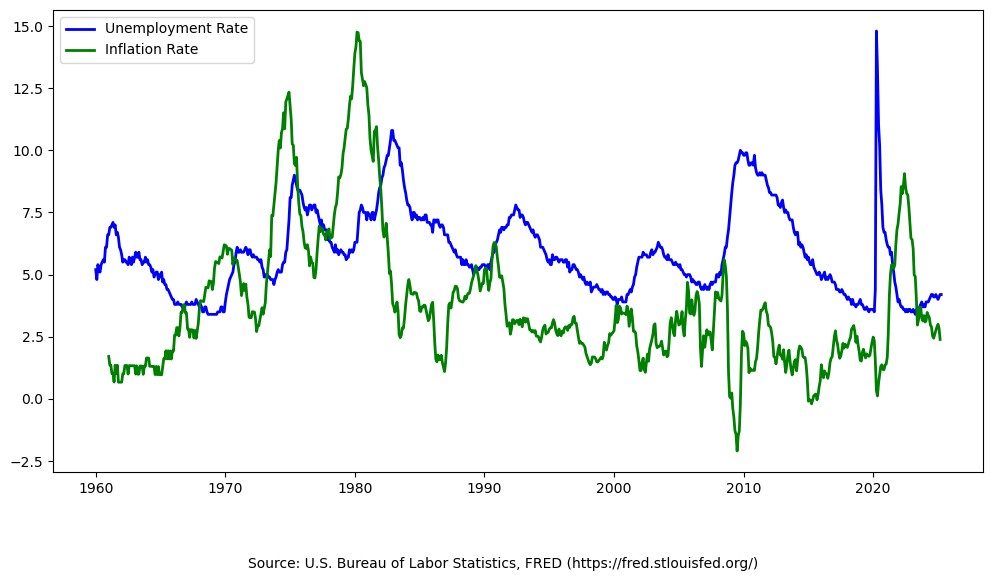

In [9]:
# 绘图：失业率 + 通货膨胀率
plt.figure(figsize=(12, 6))

# 绘制失业率
plt.plot(df_unemp.index, df_unemp["UNRATE"], 
         color='blue', linewidth=2, label='Unemployment Rate')

# 绘制通货膨胀率
plt.plot(df_CPI.index, df_CPI['Inflation Rate'], 
         color='green', linewidth=2, label='Inflation Rate')

# 添加图例
plt.legend(loc='upper left')

# 添加数据来源说明
plt.figtext(0.5, -0.05, "Source: U.S. Bureau of Labor Statistics, FRED (https://fred.stlouisfed.org/)", 
            wrap=True, horizontalalignment='center', fontsize=10)


这幅图展示了 1960 年至今美国 **失业率（Unemployment Rate）** 与 **通胀率（Inflation Rate）** 的时间序列走势。可以从以下几个方面进行解读：

* **趋势与波动性差异**：

  * 失业率（蓝线）表现出相对平稳的周期性波动，具有一定的周期长度；
  * 通胀率（绿线）波动幅度更大，尤其在 1970s 至 1980s 初期，有显著的尖峰。

* **结构性事件的影响**：

  * 1970s：石油危机期间，通胀迅速上升至 13% 以上（即“滞涨”现象），而失业率也居高不下；
  * 2008 金融危机：失业率大幅上升，而通胀保持较低水平；
  * 2020 疫情冲击：失业率暴涨，通胀短暂回落，随后于 2021-2022 再次激增。

* **负相关性阶段**：

  * 在部分阶段（例如 1980s 中后期、1990s、2010s），通胀与失业呈现出某种程度的负相关，符合传统的菲利普斯曲线（Phillips Curve）设定。


### 建模思路

如果我们想建立一个模型来刻画失业率与通胀率之间的关系，有哪些可行的建模思路呢？

- 线性回归
- ARMA 模型
- VAR 模型
- VECM 模型

In [32]:
# UNRATE 和 Inflation Rate 的关系

## 相关系数
correlation = df_unemp["UNRATE"].corr(df_CPI['Inflation Rate'])
print(f"Correlation between Unemployment Rate and Inflation Rate: {correlation:.2f}")

## OLS 回归分析
import statsmodels.api as sm
# Align the indices of X and Y
X = df_CPI['Inflation Rate'].dropna()   # 自变量
Y = df_unemp["UNRATE"]                  # 因变量
X, Y = X.align(Y, join='inner')         # Align indices
X = sm.add_constant(X)                  # 添加常数项
model = sm.OLS(Y, X).fit()              # OLS 回归
model_summary = model.summary()       # 回归结果
print(model_summary)


Correlation between Unemployment Rate and Inflation Rate: 0.06
                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.016
Date:                Tue, 06 May 2025   Prob (F-statistic):             0.0829
Time:                        00:52:40   Log-Likelihood:                -1505.1
No. Observations:                 771   AIC:                             3014.
Df Residuals:                     769   BIC:                             3024.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [34]:
# ARMA (1,1) 模型：失业率
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

model_unemp = ARIMA(df_unemp['UNRATE'].dropna(), order=(1, 0, 1))
model_unemp_fit = model_unemp.fit()  # Fit the ARIMA model
print(model_unemp_fit.summary())  # Print the model summary

                               SARIMAX Results                                
Dep. Variable:                 UNRATE   No. Observations:                  784
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -446.406
Date:                Tue, 06 May 2025   AIC                            900.812
Time:                        00:54:53   BIC                            919.469
Sample:                    01-01-1960   HQIC                           907.986
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8040      1.075      5.397      0.000       3.696       7.912
ar.L1          0.9640      0.012     82.124      0.000       0.941       0.987
ma.L1          0.0508      0.012      4.417      0.0

In [35]:
# ARMA (1,1) 模型：通胀率

model = ARIMA(df_CPI['Inflation Rate'].dropna(), order=(1, 0, 1))
model_fit = model.fit()     # Fit the ARIMA model
print(model_fit.summary())  # Print the model summary

                               SARIMAX Results                                
Dep. Variable:         Inflation Rate   No. Observations:                  771
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -327.515
Date:                Tue, 06 May 2025   AIC                            663.030
Time:                        00:55:03   BIC                            681.621
Sample:                    01-01-1961   HQIC                           670.185
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5391      1.139      3.108      0.002       1.307       5.771
ar.L1          0.9847      0.005    197.487      0.000       0.975       0.995
ma.L1          0.2964      0.026     11.248      0.0

### 单位根检验

从上面的 $ARMA(1,1)$ 模型的结果来看，$AR(1)$ 系数的估计值为 $0.9847$，接近于 $1$，这表明该序列可能是一个单位根序列。

我们可以使用 `statsmodels` 库中的 `adfuller` 函数来进行单位根检验。

#### ADF 检验
给定一个时间序列 $X_t$，我们可以使用以下的 ADF 检验来检验 $X_t$ 是否是平稳的：

$$
X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \epsilon_t$$

其中，$\epsilon_t$ 是一个白噪声序列。

ADF 检验的原假设是：$X_t$ 是一个单位根序列，即 $H_0: \phi_1 = 1$。
如果 $H_0$ 被拒绝，则说明 $X_t$ 是平稳的。

ADF 检验包含几种典型的数据生成机制：

- 纯随机游走：$X_t = X_{t-1} + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列。
- 随机游走加趋势：$X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 t + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列，$t$ 是时间趋势项。
- 随机游走加季节性：$X_t = \phi_0 + \phi_1 X_{t-1} + S_t + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列，$S_t$ 是季节性项。
- 随机游走加趋势和季节性：$X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 t + S_t + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列，$t$ 是时间趋势项，$S_t$ 是季节性项。

#### KPSS 检验
KPSS 检验的原假设是：$X_t$ 是平稳的，即 $H_0: \phi_1 < 1$。
如果 $H_0$ 被拒绝，则说明 $X_t$ 是一个单位根序列。

#### PP 检验
PP 检验的原假设是：$X_t$ 是一个单位根序列，即 $H_0: \phi_1 = 1$。
如果 $H_0$ 被拒绝，则说明 $X_t$ 是平稳的。

#### 对比


In [15]:
# 定义单位根检验函数（支持多种形式）
def unit_root_tests(series, series_name, regression_type='c'):
    """
    单位根检验函数，支持多种形式的回归类型。
    
    参数:
    - series: 时间序列数据 (pandas.Series)
    - series_name: 序列名称 (str)
    - regression_type: 回归类型 (str)，可选值为：
        'c' - 常数项
        'ct' - 常数项 + 时间趋势
        'ctt' - 常数项 + 时间趋势 + 二次趋势
        'nc' - 无常数项
    """
    print(f"单位根检验结果 ({regression_type}): {series_name}")
    print("-" * 50)
    
    # ADF 检验
    adf_result = adfuller(series.dropna(), regression=regression_type)
    print("ADF 检验:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print(f"Critical Values: {adf_result[4]}")
    print(f"Conclusion: {'Reject H0 (Stationary)' if adf_result[1] < 0.05 else 'Fail to Reject H0 (Non-Stationary)'}")
    print("-" * 50)
    
    # KPSS 检验
    kpss_result = kpss(series.dropna(), regression=regression_type)
    print("KPSS 检验:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print(f"Critical Values: {kpss_result[3]}")
    print(f"Conclusion: {'Reject H0 (Non-Stationary)' if kpss_result[1] < 0.05 else 'Fail to Reject H0 (Stationary)'}")
    print("=" * 50)

# 针对失业率序列进行单位根检验（原始序列和包含时间趋势）
unit_root_tests(df_unemp['UNRATE'], "Unemployment Rate", regression_type='c')  # 常数项
unit_root_tests(df_unemp['UNRATE'], "Unemployment Rate", regression_type='ct')  # 常数项 + 时间趋势

# 针对通货膨胀率序列进行单位根检验（原始序列和包含时间趋势）
unit_root_tests(df_CPI['Inflation Rate'], "Inflation Rate", regression_type='c')  # 常数项
unit_root_tests(df_CPI['Inflation Rate'], "Inflation Rate", regression_type='ct')  # 常数项 + 时间趋势


单位根检验结果 (c): Unemployment Rate
--------------------------------------------------
ADF 检验:
ADF Statistic: -3.3770
p-value: 0.0118
Critical Values: {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}
Conclusion: Reject H0 (Stationary)
--------------------------------------------------
KPSS 检验:
KPSS Statistic: 0.2311
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Conclusion: Fail to Reject H0 (Stationary)
单位根检验结果 (ct): Unemployment Rate
--------------------------------------------------
ADF 检验:
ADF Statistic: -3.3937
p-value: 0.0522
Critical Values: {'1%': -3.97040856520887, '5%': -3.416126420192948, '10%': -3.130367109217753}
Conclusion: Fail to Reject H0 (Non-Stationary)
--------------------------------------------------
KPSS 检验:
KPSS Statistic: 0.2188
p-value: 0.0100
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Conclusion: Reject H0 (Non-Stationary)
单位根检验结果 (c): Inflation Rate
------------

C:\Users\arlio\AppData\Local\Temp\ipykernel_20436\554256670.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression=regression_type)
C:\Users\arlio\AppData\Local\Temp\ipykernel_20436\554256670.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression=regression_type)
C:\Users\arlio\AppData\Local\Temp\ipykernel_20436\554256670.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression=regression_type)
C:\Users\arlio\AppData\Local\Temp\ipykernel_20436\554256670.py:28: InterpolationWarning: The test st

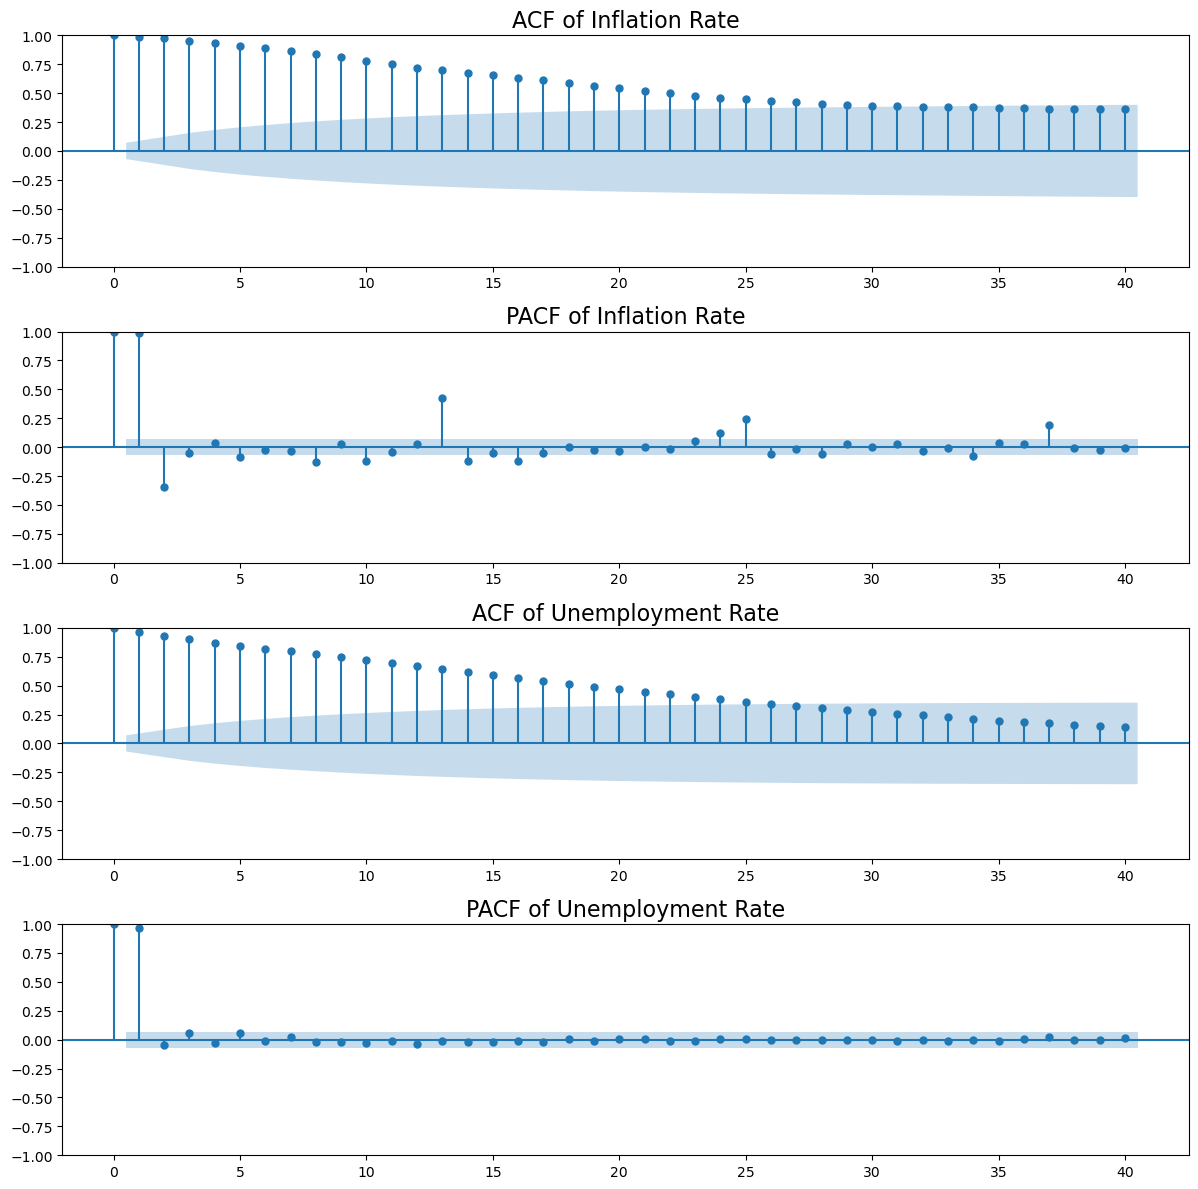

In [16]:
# 绘制 ACF 和 PACF 图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 12))

# 通胀率的 ACF 和 PACF
plt.subplot(4, 1, 1)
plot_acf(df_CPI['Inflation Rate'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Inflation Rate', fontsize=16)

plt.subplot(4, 1, 2)
plot_pacf(df_CPI['Inflation Rate'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF of Inflation Rate', fontsize=16)

# 失业率的 ACF 和 PACF
plt.subplot(4, 1, 3)
plot_acf(df_unemp['UNRATE'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Unemployment Rate', fontsize=16)

plt.subplot(4, 1, 4)
plot_pacf(df_unemp['UNRATE'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF of Unemployment Rate', fontsize=16)

plt.tight_layout()
plt.show()

解读：
上面的图形展示了美国失业率和通货膨胀率的时间序列变化趋势。可以观察到，失业率和通货膨胀率在不同时间段内呈现出一定的波动性。失业率在经济衰退期间通常会显著上升，而通货膨胀率则可能受到多种因素的影响，包括货币政策、供需变化等。通过对比两条曲线，可以进一步分析它们之间的关系，例如是否存在菲利普斯曲线的特征。此外，结合回归分析和相关系数的计算结果，可以定量评估失业率与通货膨胀率之间的相关性。

## VAR 模型
### 什么是 VAR 模型？

向量自回归模型（Vector Autoregression, VAR）是一种多元时间序列模型，用于捕捉多个变量之间的动态关系。它假设每个变量不仅受自身滞后值的影响，还受到其他变量滞后值的影响。

#### VAR(2) 模型的形式

以两个变量 $y_t$ 和 $x_t$ 为例，VAR(2) 模型的形式如下：

$$
\begin{aligned}
y_t &= a_{10} + a_{11} y_{t-1} + a_{12} x_{t-1} + a_{13} y_{t-2} + a_{14} x_{t-2} + \epsilon_{y,t}, \\
x_t &= a_{20} + a_{21} y_{t-1} + a_{22} x_{t-1} + a_{23} y_{t-2} + a_{24} x_{t-2} + \epsilon_{x,t},
\end{aligned}
$$

其中：

- $y_t$ 和 $x_t$ 是两个时间序列变量；
- $a_{ij}$ 是模型系数；
- $\epsilon_{y,t}$ 和 $\epsilon_{x,t}$ 是误差项，通常假设为白噪声。

#### VAR(P) 模型的扩展

VAR(P) 模型是 VAR(2) 模型的推广形式，表示包含 $P$ 阶滞后项的向量自回归模型。其一般形式为：

$$
Y_t = A_1 Y_{t-1} + A_2 Y_{t-2} + \dots + A_P Y_{t-P} + \epsilon_t,
$$

其中：

- $Y_t$ 是包含多个变量的向量（如 $[y_t, x_t]^\top$）；
- $A_1, A_2, \dots, A_P$ 是系数矩阵；
- $\epsilon_t$ 是误差项。

通过增加滞后阶数 $P$，VAR 模型可以捕捉更复杂的动态关系，但也可能导致参数过多的问题。因此，选择合适的滞后阶数是建模中的关键步骤。


### VAR 模型的估计

在 VAR 模型中，估计的核心任务是确定模型的滞后阶数，并对模型参数进行估计。以下是 VAR 模型估计的主要步骤：

#### 1. 数据准备
确保时间序列数据是平稳的。如果数据非平稳，可以通过差分或其他变换使其平稳。

#### 2. 滞后阶数选择
滞后阶数的选择可以通过信息准则（如 AIC、BIC、HQIC）来完成。一般来说，滞后阶数越高，模型的拟合效果越好，但也可能导致过拟合。

#### 3. 模型估计
使用最小二乘法（OLS）对 VAR 模型的参数进行估计。每个方程可以独立估计，因为 VAR 模型假设误差项之间是独立的。

#### 4. 模型诊断
对残差进行诊断，检查是否存在自相关、异方差等问题。如果存在问题，可以调整模型或使用其他方法进行改进。

#### 5. 结果解释
分析模型的系数估计值，解释变量之间的动态关系。

以下是一个基于 Python 的 VAR 模型估计示例：

In [20]:
from statsmodels.tsa.api import VAR

# 准备数据：将失业率和通胀率合并为一个 DataFrame
data = pd.concat([df_unemp['UNRATE'], df_CPI['Inflation Rate']], axis=1).dropna()
data.columns = ['Unemployment Rate', 'Inflation Rate']

# 创建 VAR 模型
model = VAR(data)

# 选择滞后阶数（使用 AIC 或 BIC）
lag_order = model.select_order(maxlags=15)
print("Lag Order Selection:")
print(lag_order.summary())

# 根据选择的滞后阶数拟合 VAR 模型
optimal_lag = lag_order.aic  # 使用 AIC 选择的滞后阶数


Lag Order Selection:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.154       3.167       23.44       3.159
1       -3.583      -3.546     0.02779      -3.569
2       -3.721     -3.659*     0.02422      -3.697
3       -3.718      -3.632     0.02429      -3.685
4       -3.710      -3.600     0.02448      -3.667
5       -3.711      -3.577     0.02444      -3.659
6       -3.703      -3.543     0.02466      -3.641
7       -3.698      -3.514     0.02478      -3.627
8       -3.703      -3.495     0.02465      -3.623
9       -3.693      -3.461     0.02489      -3.604
10      -3.700      -3.443     0.02473      -3.601
11      -3.693      -3.411     0.02490      -3.585
12      -3.685      -3.379     0.02510      -3.567
13      -3.916      -3.585     0.01992      -3.789
14     -3.934*      -3.579    0.01957*     -3.797*
15      -3.928      -3.548     0.01968      -3.782
----------

由此可以看出，我们设定一个 VAR(2) 模型即可。

In [21]:
# 拟合 VAR(2) 模型
var_model_2 = model.fit(2)

# 输出模型结果
print(var_model_2.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     18:30:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.66800
Nobs:                     769.000    HQIC:                  -3.70515
Log likelihood:          -738.758    FPE:                  0.0240313
AIC:                     -3.72840    Det(Omega_mle):       0.0237218
--------------------------------------------------------------------
Results for equation Unemployment Rate
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.164239         0.058576            2.804           0.005
L1.Unemployment Rate         0.988192         0.036480           27.089           0.000
L1.Inflation Rate   

### Granger 因果检验

Granger 因果检验的核心思想是通过回归分析判断一个变量的滞后值是否能够显著提高对另一个变量的预测能力。以下是 Granger 因果检验的数学公式及其在失业率 $u$ 和通胀率 $e$ 上的应用。

#### 1. 单变量回归模型
首先，构建仅包含因变量自身滞后项的回归模型：

$$
u_t = \alpha_0 + \sum_{i=1}^p \alpha_i u_{t-i} + \epsilon_t
$$

其中：

- $u_t$ 表示当前的失业率；
- $u_{t-i}$ 表示失业率的第 $i$ 阶滞后值；
- $\epsilon_t$ 是误差项。

#### 2. 多变量回归模型
然后，构建同时包含因变量和另一个变量滞后项的回归模型：

$$
u_t = \beta_0 + \sum_{i=1}^p \beta_i u_{t-i} + \sum_{j=1}^q \gamma_j e_{t-j} + \eta_t
$$

其中：

- $e_{t-j}$ 表示通胀率的第 $j$ 阶滞后值；
- $\eta_t$ 是误差项。

#### 3. 检验假设
通过 F 检验比较上述两个模型的拟合优度，检验以下假设：

- 原假设 $H_0$：$e_{t-j}$ 的系数 $\gamma_j = 0$，即通胀率的滞后值对失业率没有显著影响；
- 备择假设 $H_1$：$e_{t-j}$ 的系数 $\gamma_j \neq 0$，即通胀率的滞后值对失业率有显著影响。

#### 示例：失业率与通胀率的 Granger 因果检验

以下是基于失业率 $u$ 和通胀率 $e$ 的 Granger 因果检验代码示例：

In [26]:
from statsmodels.tsa.stattools import grangercausalitytests

# Granger 因果检验
# 检验失业率 (u) 是否是通胀率 (e) 的 Granger 因，以及反向关系
max_lag = 14  # 最大滞后阶数
granger_test_result_u_to_e = grangercausalitytests(data[['Inflation Rate', 'Unemployment Rate']], max_lag, verbose=False)
granger_test_result_e_to_u = grangercausalitytests(data[['Unemployment Rate', 'Inflation Rate']], max_lag, verbose=False)

# 提取 Granger 因果检验结果并汇总成表格
def extract_granger_results(granger_test_result):
    granger_summary = []
    for lag, result in granger_test_result.items():
        f_stat = result[0]['ssr_ftest'][0]
        p_value = result[0]['ssr_ftest'][1]
        granger_summary.append({'Lag': lag, 'F-statistic': f_stat, 'p-value': p_value})
    return pd.DataFrame(granger_summary)

# 汇总结果
granger_summary_u_to_e = extract_granger_results(granger_test_result_u_to_e)
granger_summary_e_to_u = extract_granger_results(granger_test_result_e_to_u)

# 显示结果表格
print("Granger Causality Test Summary (u -> e):")
print(granger_summary_u_to_e)
print("\nGranger Causality Test Summary (e -> u):")
print(granger_summary_e_to_u)

# 给出最终结论
significant_lags_u_to_e = granger_summary_u_to_e[granger_summary_u_to_e['p-value'] < 0.05]
significant_lags_e_to_u = granger_summary_e_to_u[granger_summary_e_to_u['p-value'] < 0.05]

if not significant_lags_u_to_e.empty:
    print("\n结论：失业率 (u) 是通胀率 (e) 的 Granger 因，显著滞后阶数如下：")
    print(significant_lags_u_to_e)
else:
    print("\n结论：失业率 (u) 不是通胀率 (e) 的 Granger 因。")

if not significant_lags_e_to_u.empty:
    print("\n结论：通胀率 (e) 是失业率 (u) 的 Granger 因，显著滞后阶数如下：")
    print(significant_lags_e_to_u)
else:
    print("\n结论：通胀率 (e) 不是失业率 (u) 的 Granger 因。")

Granger Causality Test Summary (u -> e):
    Lag  F-statistic   p-value
0     1     5.471488  0.019585
1     2     0.647864  0.523449
2     3     0.436910  0.726650
3     4     0.610716  0.655024
4     5     0.375923  0.865353
5     6     0.495935  0.811649
6     7     0.557345  0.790737
7     8     0.514758  0.845838
8     9     0.506870  0.870126
9    10     0.705498  0.719822
10   11     0.685244  0.753382
11   12     0.614399  0.831097
12   13     0.822097  0.636812
13   14     0.747766  0.726348

Granger Causality Test Summary (e -> u):
    Lag  F-statistic   p-value
0     1     5.450546  0.019819
1     2     6.978787  0.000992
2     3     5.220735  0.001427
3     4     3.865455  0.004070
4     5     3.254972  0.006472
5     6     2.676468  0.014124
6     7     2.425017  0.018447
7     8     2.141302  0.030061
8     9     1.867208  0.053700
9    10     1.654286  0.087485
10   11     1.511173  0.122295
11   12     1.386544  0.166729
12   13     1.357478  0.174610
13   14     1.3893

## 脉冲响应分析

### 什么是脉冲响应分析？

脉冲响应分析（Impulse Response Analysis）是时间序列分析中的一种重要工具，用于研究系统对外部冲击的动态反应。具体来说，在向量自回归模型（VAR）中，脉冲响应分析可以帮助我们回答以下问题：

- 当某个变量受到一个单位冲击时，其他变量会如何反应？
- 这种反应会持续多长时间？
- 反应的方向和强度如何？

### 数学定义

假设我们有一个 VAR(p) 模型：

$$
Y_t = A_1 Y_{t-1} + A_2 Y_{t-2} + \dots + A_p Y_{t-p} + \epsilon_t
$$

其中：

- $Y_t$ 是包含多个变量的向量；
- $A_i$ 是系数矩阵；
- $\epsilon_t$ 是误差项。

脉冲响应函数（Impulse Response Function, IRF）描述了 $Y_t$ 中某个变量对 $\epsilon_t$ 中某个分量的单位冲击的动态反应。

### 分析步骤

1. **拟合 VAR 模型**：首先需要对时间序列数据拟合一个 VAR 模型。
2. **计算脉冲响应函数**：基于拟合的 VAR 模型，计算各变量对冲击的响应。
3. **绘制脉冲响应图**：将响应结果可视化，便于直观理解。

### 示例：失业率与通胀率的脉冲响应分析

以下是基于失业率和通胀率的脉冲响应分析步骤：

1. **拟合 VAR 模型**：我们已经拟合了一个 VAR(2) 模型。
2. **计算脉冲响应函数**：使用 `statsmodels` 提供的工具计算脉冲响应。
3. **绘制脉冲响应图**：展示失业率和通胀率对冲击的动态反应。

### 代码实现

以下是脉冲响应分析的代码示例：


<Figure size 1200x800 with 0 Axes>

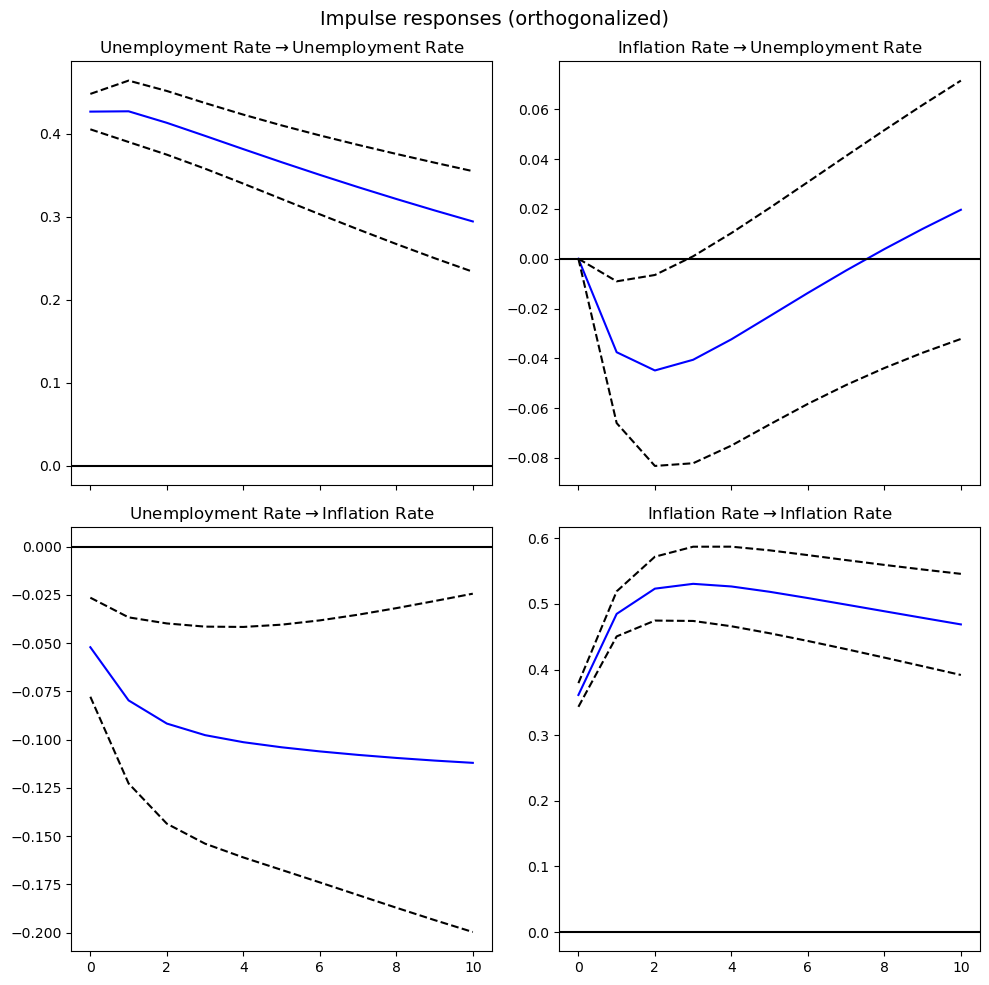

In [27]:
# 脉冲响应分析 (Impulse Response Function, IRF)
irf = var_model_2.irf(10)  # 计算 10 期的脉冲响应

# 绘制 IRF 图
plt.figure(figsize=(12, 8))
irf.plot(orth=True)  # orth=True 表示正交化脉冲响应
plt.tight_layout()
plt.show()

上面的图形展示了失业率和通货膨胀率的脉冲响应分析结果，具体解读如下：

1. **失业率对自身冲击的响应**：
    - 失业率在受到自身冲击后，短期内会出现显著的正向反应，随后逐渐回归到长期均衡水平。
    - 这种现象表明失业率具有一定的惯性效应，即当前的失业率水平会受到过去水平的显著影响。

2. **通货膨胀率对自身冲击的响应**：
    - 通货膨胀率在受到自身冲击后，也会出现短期的正向反应，但其回归速度较快。
    - 这表明通货膨胀率的波动性较高，但其长期趋势相对稳定。

3. **失业率对通货膨胀率冲击的响应**：
    - 失业率在受到通货膨胀率冲击后，可能会出现短暂的负向反应，随后逐渐回归均衡。
    - 这种负相关性可能与菲利普斯曲线的理论一致，即在短期内失业率和通货膨胀率之间存在一定的替代关系。

4. **通货膨胀率对失业率冲击的响应**：
    - 通货膨胀率在受到失业率冲击后，反应较为温和，且回归速度较快。
    - 这表明失业率的变化对通货膨胀率的长期影响较小，但可能会在短期内引发一定的波动。

### 总结
通过脉冲响应分析可以看出，失业率和通货膨胀率之间存在一定的动态关系，但这种关系在短期内更为显著，长期影响则趋于平稳。这为进一步的经济建模和政策分析提供了重要的参考依据。